In [1]:
import pandas as pd
import datasist as ds
pd.set_option('display.max_rows', 80)



import numpy as np
import seaborn as sns
from tqdm import tqdm, trange
from tabulate import tabulate
from statistics import mean
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold, TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error 


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86584 entries, 0 to 86583
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID_Zindi            86584 non-null  object 
 1   Date                86584 non-null  object 
 2   ID                  86584 non-null  object 
 3   LAT                 86584 non-null  float64
 4   LON                 86584 non-null  float64
 5   Precipitation       86584 non-null  float64
 6   LST                 46798 non-null  float64
 7   AAI                 73709 non-null  float64
 8   CloudFraction       73709 non-null  float64
 9   NO2_strat           73709 non-null  float64
 10  NO2_total           73709 non-null  float64
 11  NO2_trop            51111 non-null  float64
 12  TropopausePressure  73709 non-null  float64
 13  GT_NO2              82051 non-null  float64
dtypes: float64(11), object(3)
memory usage: 9.2+ MB


In [4]:
ds.structdata.display_missing(train)

,features,missing_counts,missing_percent
0,ID_Zindi,0,0.0
1,Date,0,0.0
2,ID,0,0.0
3,LAT,0,0.0
4,LON,0,0.0
5,Precipitation,0,0.0
6,LST,39786,46.0
7,AAI,12875,14.9
8,CloudFraction,12875,14.9
9,NO2_strat,12875,14.9


In [5]:
ds.structdata.display_missing(test)

,features,missing_counts,missing_percent
0,ID_Zindi,0,0.0
1,Date,0,0.0
2,ID,0,0.0
3,LAT,0,0.0
4,LON,0,0.0
5,Precipitation,0,0.0
6,LST,2981,45.3
7,AAI,868,13.2
8,CloudFraction,868,13.2
9,NO2_strat,868,13.2


In [6]:
def to_datetime (data):
    data['Date'] = pd.to_datetime(data['Date'])
    return data
train = to_datetime(train)
test = to_datetime(test)

In [7]:
by_ID = train.groupby('ID')
by_id = test.groupby('ID')


def imputation (series):
    return series.fillna(series.mean())

missing_column =['LAT', 'LON', 'Precipitation', 'LST', 'AAI',
       'CloudFraction', 'NO2_strat', 'NO2_total', 'NO2_trop',
       'TropopausePressure' ]

for col in missing_column:
    train[col] = by_ID[col].transform(imputation)
    test[col] = by_id[col].transform(imputation)
    
train= train.dropna()        

In [8]:
num_feats = ds.structdata.get_num_feats(train)
location = train.groupby(['ID', 'Date'])[num_feats].mean().reset_index()
location = location.groupby(['ID'])[num_feats].mean().reset_index()

In [9]:
train

,ID_Zindi,Date,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2
0,ID_ENTGC7,2019-01-01,PD01,45.601585,11.903551,0.000000,298.024610,0.230527,0.559117,0.000024,0.000117,0.000079,14440.821260,31.000
1,ID_8JCCXC,2019-01-01,PD04,45.371005,11.840830,3.047342,299.420472,-0.074006,0.869309,0.000024,0.000127,0.000090,14441.798150,42.000
2,ID_V3136Z,2019-01-01,RO01,45.045825,12.060869,0.000000,300.112157,0.024470,0.674160,0.000024,0.000086,0.000059,14437.382940,31.000
3,ID_KRVZDJ,2019-01-01,RO02,45.104075,11.553241,1.200467,299.552581,-0.010442,0.920054,0.000024,0.000124,0.000069,14440.838310,30.000
4,ID_PR351A,2019-01-01,RO03,45.038758,11.790152,1.274564,301.427155,-0.176178,0.747464,0.000024,0.000116,0.000065,14438.790370,58.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86579,ID_NCWXIY,2021-12-31,X9897,45.498227,9.556232,0.000000,299.672589,-0.434350,0.250490,0.000032,0.000643,0.000112,13063.797700,39.750
86580,ID_UDQIEE,2021-12-31,X9928,45.142541,10.043836,0.000000,300.346974,-1.283089,0.189734,0.000046,0.000141,0.000082,16642.054239,30.125
86581,ID_ENDUPX,2021-12-31,X9969,45.842207,9.351658,0.000000,284.980000,-0.157753,0.000000,0.000031,0.000153,0.000122,13050.164990,28.325
86582,ID_3ZBA6C,2021-12-31,X9993,45.113503,8.874065,0.000000,298.478264,-0.798636,0.399524,0.000031,0.000717,0.000080,13061.413290,21.250


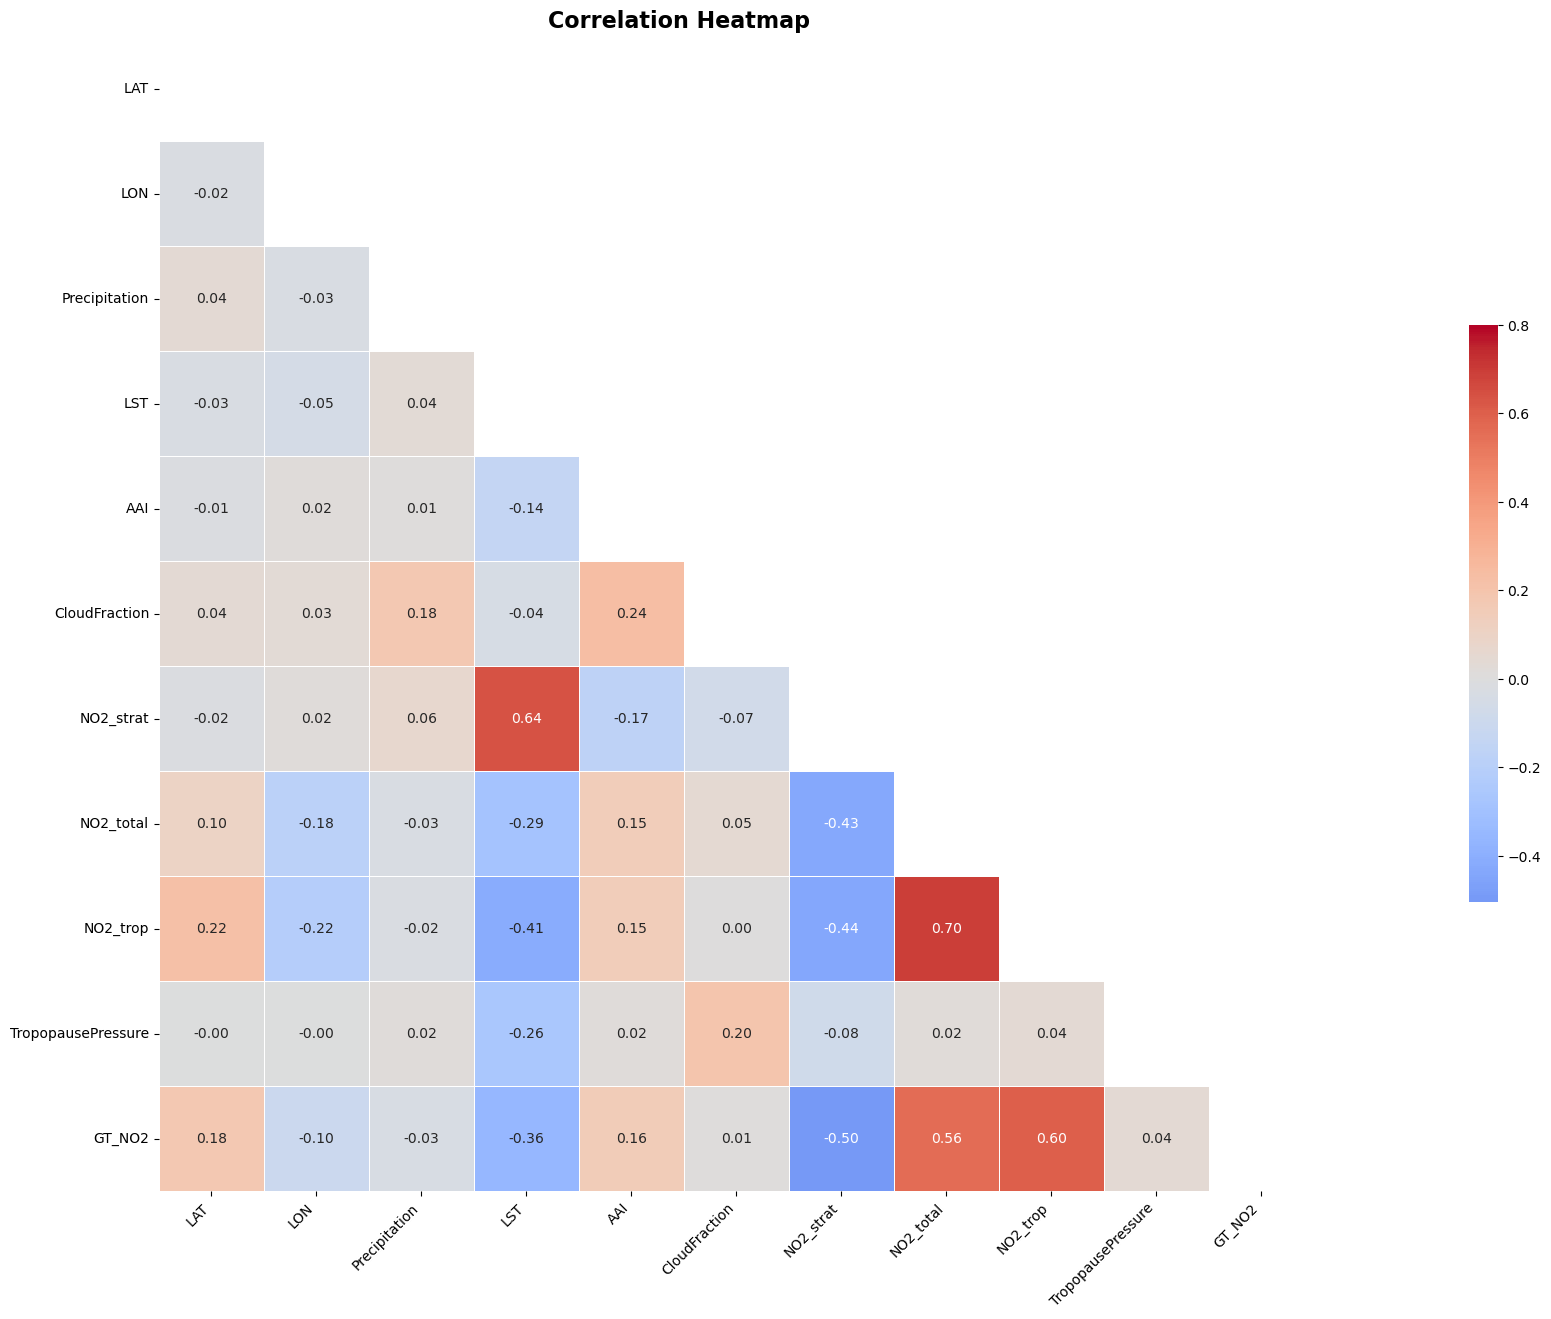

In [10]:
#CORRELATION BETWEEN THE INDEPENDENTS FEATURES AND THE TARGETS COLUMNS
#HEATMAP PLOT 

corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(40, 15))

heatmap = sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=.8, center=0,
            annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

title = heatmap.set_title("Correlation Heatmap", weight='bold', size=16)
title.set_position([0.45, 1.1])
plt.show()

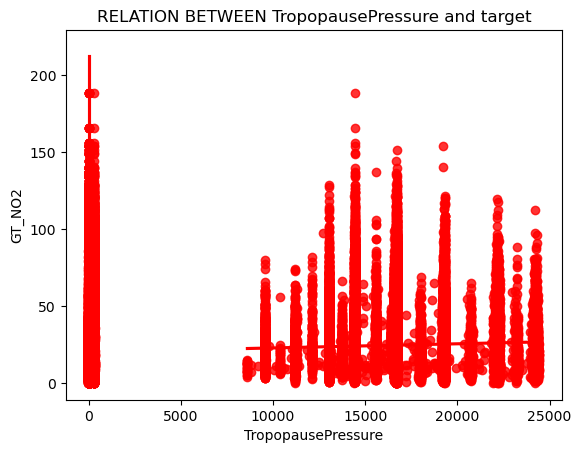

In [11]:
"""
for col in num_feats:
    if col == 'GT_NO2':
        continue
    plt.title(f'RELATION BETWEEN {col} and target')
    sns.regplot(x = train[col], y = train['GT_NO2'], data=train, color='r')
    
"""    

In [12]:
infinity_val = np.isinf(train[num_feats]).sum()
infinity_val

LAT                   0
LON                   0
Precipitation         0
LST                   0
AAI                   0
CloudFraction         0
NO2_strat             0
NO2_total             0
NO2_trop              0
TropopausePressure    0
GT_NO2                0
dtype: int64

In [13]:
def time_feat (data):
    data['Year'] = data['Date'].dt.year
    data['Month'] = data['Date'].dt.month
    data['Day'] = data['Date'].dt.day
    data['Weekday'] =data.Date.dt.weekday
    data['WeekofYear'] = data.Date.dt.weekofyear
    data['TotaL_Days'] = (data['Date'] - data['Date'].min() ).dt.days
    data['ID'] = data['ID'].astype('category')
    data = data.drop(columns = ['Date'])
    return data

train = time_feat(train)
test = time_feat(test)

In [14]:
#HIGHLY SKEWED COLUMN IN THE TRAINING DATASET
#num_feats = ds.structdata.get_num_feats(train)
skew_list = [ ]
skew_col = [ ]
for col in num_feats:
    skew_value = train[col].skew()
    if skew_value > 0.7:
        skew_list.append(skew_value)
        skew_col.append(col) 
        
skew_result =pd.DataFrame({'Skewness_Value': skew_list}, index = skew_col)
skew_result.sort_values(by = 'Skewness_Value')

,Skewness_Value
LON,0.898648
GT_NO2,1.507939
CloudFraction,1.706948
NO2_trop,2.845308
NO2_total,4.336933
Precipitation,4.617293


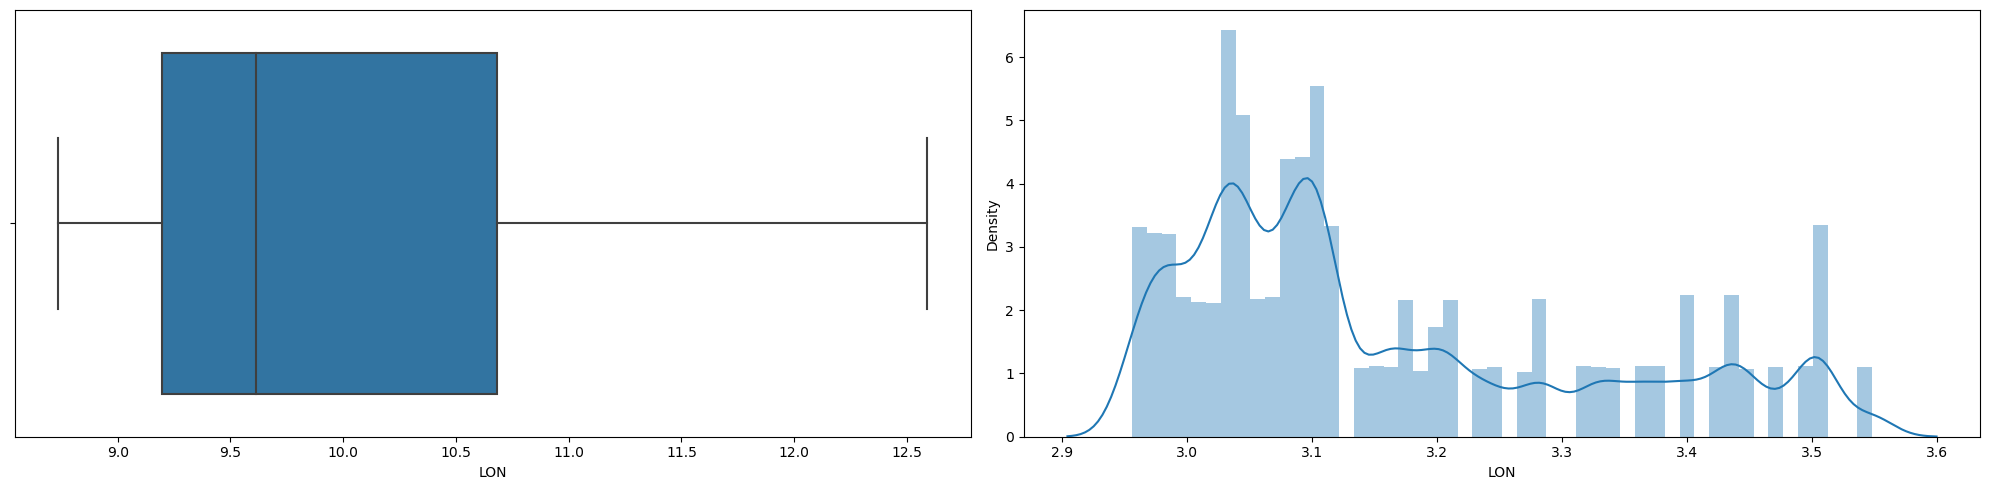

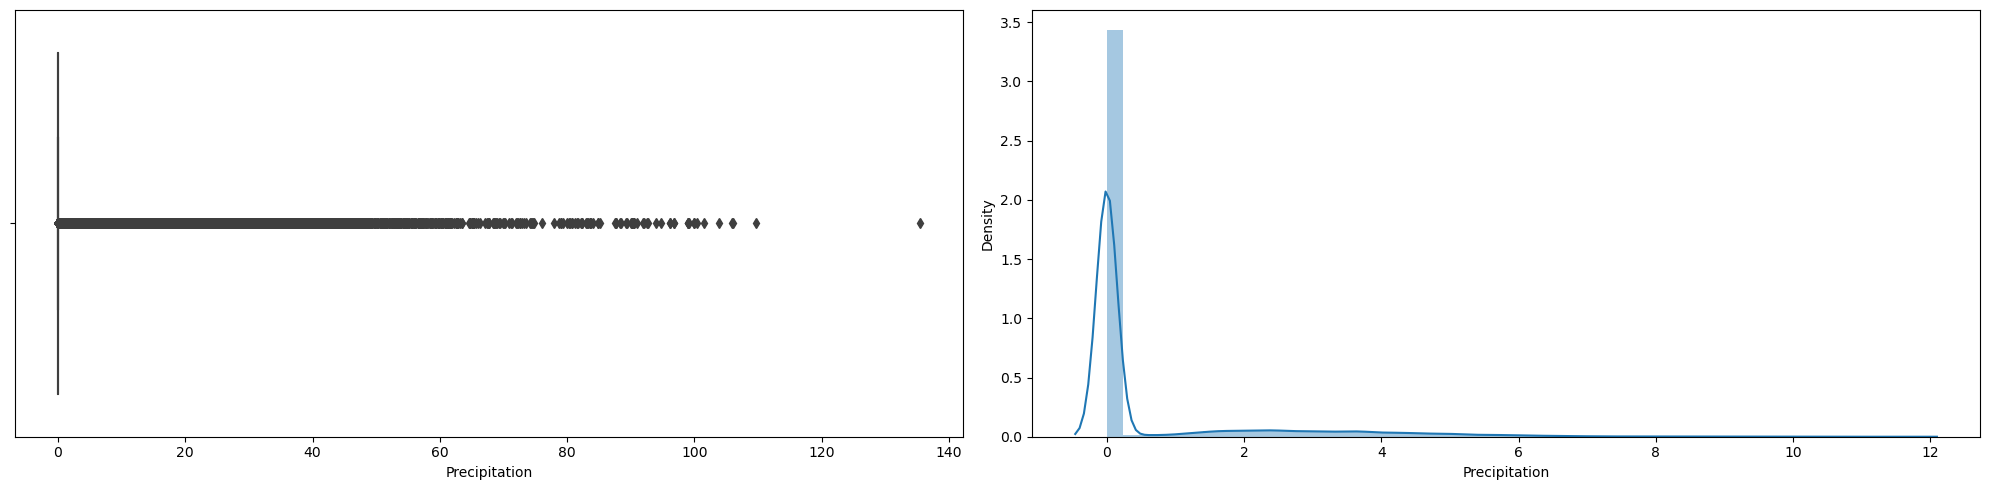

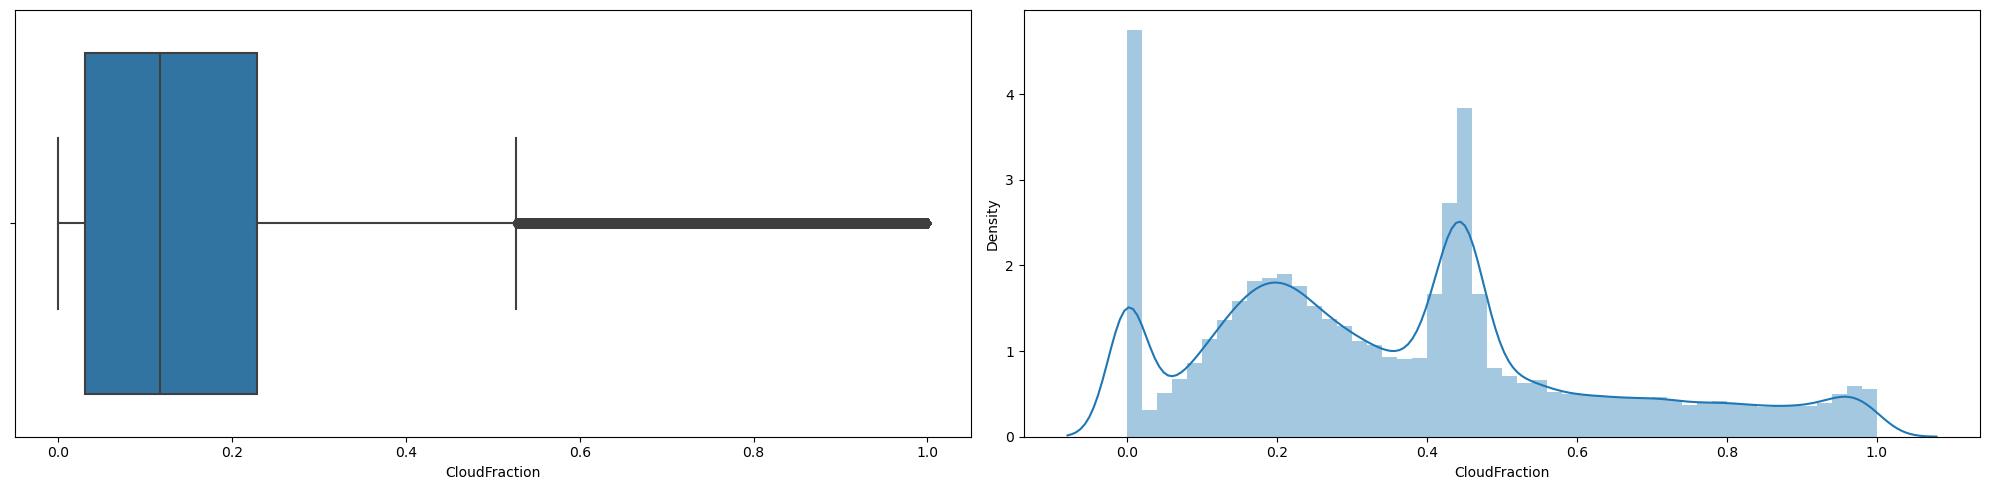

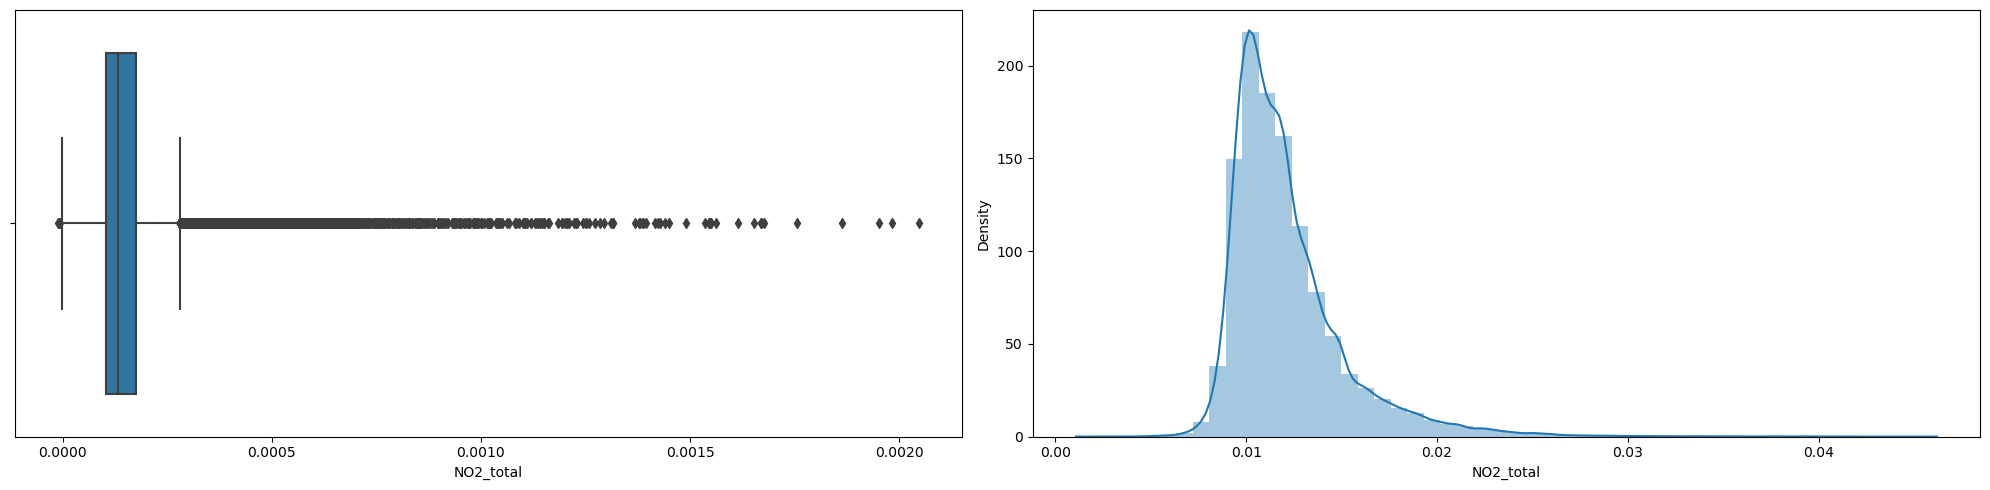

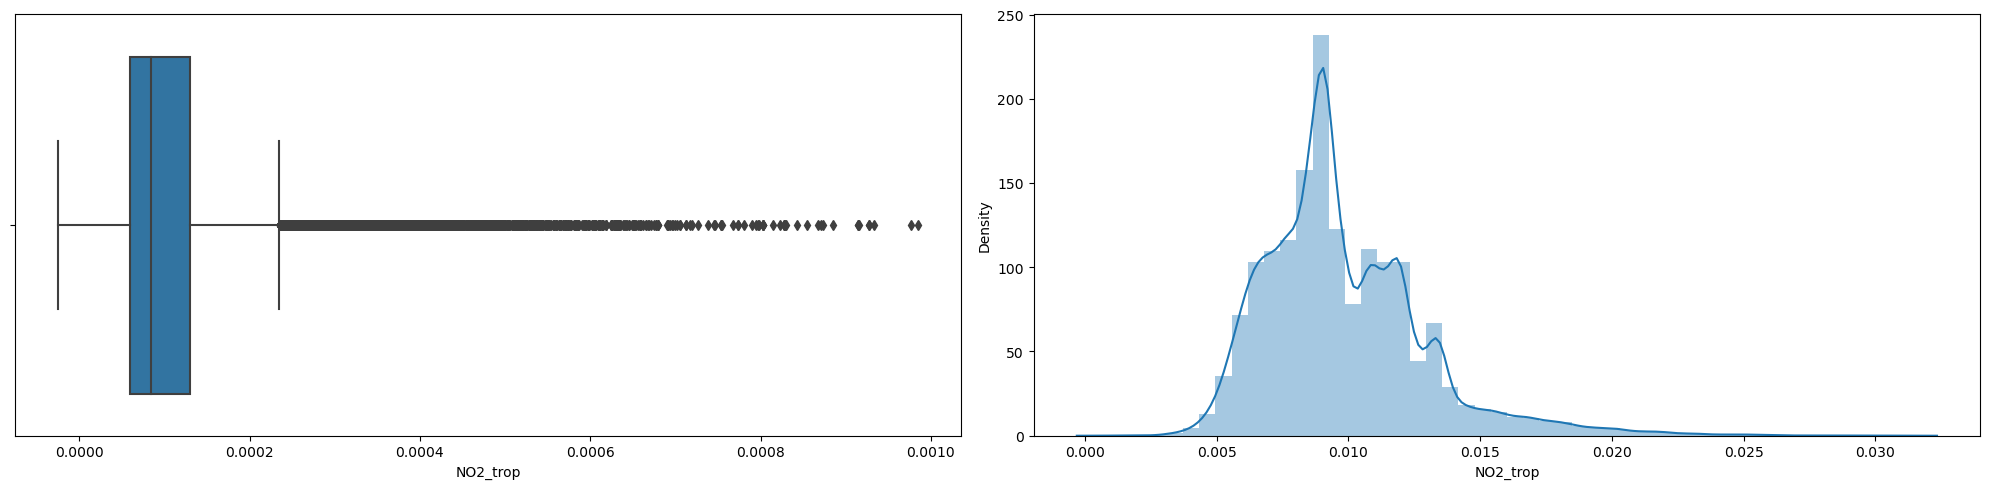

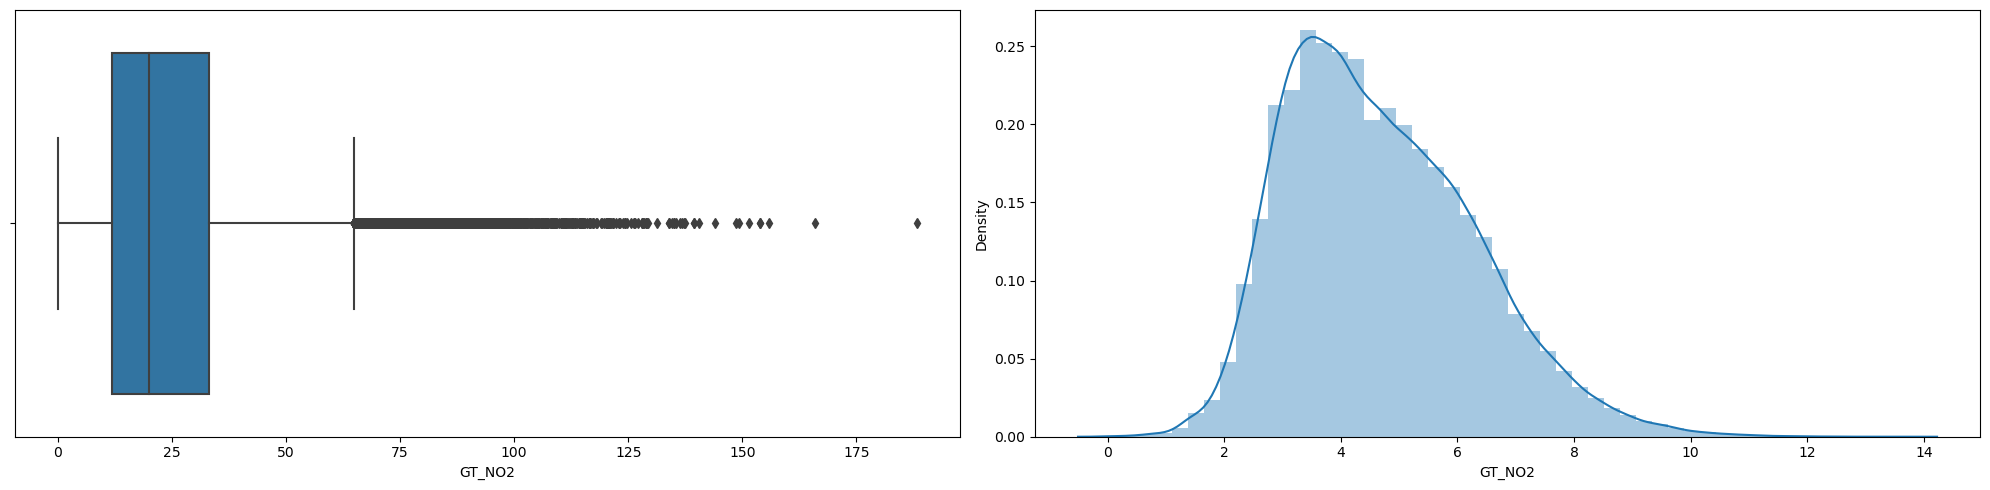

In [15]:
for col in skew_col:
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    sns.boxplot(x = train[col])
    plt.subplot(122)
    sns.distplot(train[col]) 
    plt.tight_layout()
    plt.show()

In [16]:
X_copy = train.drop(columns=['ID', 'ID_Zindi'])
y_copy = train['GT_NO2'] 

mi_scores = mutual_info_regression(X_copy, y_copy, discrete_features=X_copy.dtypes==int, n_neighbors=5, random_state=42)
mi_scores = pd.Series(mi_scores, index= X_copy.columns)
mi_scores = mi_scores.sort_values(ascending=False)

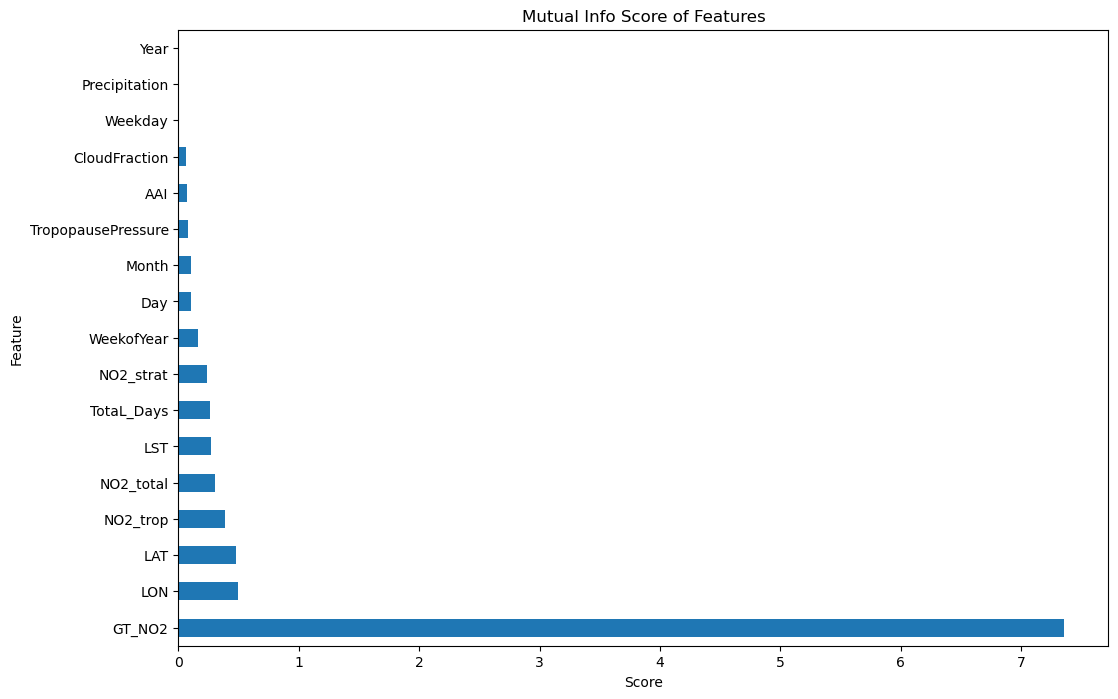

In [17]:
mi_scores.plot(kind='barh', title='Mutual Info Score of Features', figsize=(12, 8), xlabel="Score", ylabel="Feature")
plt.show()

In [18]:
%%time

test = test.drop(['ID_Zindi', 'Year'], axis=1)
X = train.drop(['ID_Zindi', 'GT_NO2', 'Year'], axis=1)
y = train['GT_NO2']
cat_features = X.select_dtypes(include=['category']).columns.tolist()

SEED = 601
n_splits = 5

def Train_ML(X, y, model, test, n_splits=n_splits):
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    rmse_scores = []
    test_preds = np.zeros((test.shape[0], n_splits)) 
    
    for fold, (train_idx, val_idx) in enumerate(tqdm(kf.split(X), total=n_splits, desc="Training Models")):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        val_predictions = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
        rmse_scores.append(rmse)
        
        test_preds[:, fold] = model.predict(test)
    
    avg_rmse = np.mean(rmse_scores)
    
    mean_test_preds = np.mean(test_preds, axis=1)
    
    header = f"\n{'Final Validation RMSE:':<25} {avg_rmse:.5f}\n"
    print(header)
    
    return mean_test_preds

lgb_params = {'learning_rate': 0.017521301504983752, 'max_depth': 42, 'reg_alpha': 0.06876635751774487, 
 'reg_lambda': 9.738899198284985, 'num_leaves': 131, 'subsample': 0.2683765421728044, 
 'colsample_bytree': 0.44346036599709887} 

params1 = {'learning_rate': 0.015387355282525047, 'num_leaves': 287, 'max_depth': 10, 'min_child_samples': 32,
 'subsample': 0.5678602068076838, 'colsample_bytree': 0.5254867750210618, 'reg_alpha': 8.515713311140541e-05,
 'reg_lambda': 9.929128235845939, 'scale_pos_weight': 1.031529653438031, 'max_bin': 2894,
 'min_split_gain': 8.135732868325528e-05, 'min_child_weight': 0.9684228603448732, 'boosting_type': 'gbdt',
 'objective': 'regression', 'metric': 'rmse'}

params2 = {'learning_rate': 0.01383980028736371, 'num_leaves': 185, 'max_depth': 11,
'min_child_samples': 47, 'subsample': 0.5179868722209913, 'colsample_bytree': 0.5099485937874763,
'reg_alpha': 2.6213681351209853e-08, 'reg_lambda': 5.24590000227586, 'scale_pos_weight': 3.6179756319298417, 
'max_bin': 2910, 'min_split_gain': 0.007117579745695504, 'min_child_weight': 0.21739378651138622}

params3 = {'learning_rate': 0.01385154226751671, 'num_leaves': 210, 'max_depth': 11, 'min_child_samples': 46,
            'subsample': 0.9986597688559038, 'colsample_bytree': 0.5087376012593833, 'reg_alpha': 0.030899363096754468, 
            'reg_lambda': 2.3890503452304634e-07, 'scale_pos_weight': 1.3428307822495738, 'max_bin': 2300,
              'min_split_gain': 0.012307088420327784, 'min_child_weight': 0.12060519419622631, 'boosting_type': 'gbdt',
 'objective': 'regression', 'metric': 'rmse'}

lgb1 = LGBMRegressor(**lgb_params, random_state=SEED, verbose=-1, n_estimators=200)
lgb2 = LGBMRegressor(**params1, random_state=SEED, verbose=-1, n_estimators=200)
lgb3 = LGBMRegressor(**params2, random_state=SEED, verbose=-1, n_estimators=200)
lgb4 = LGBMRegressor(**params3, random_state=SEED, verbose=-1, n_estimators=200)

estimator1 = VotingRegressor([
    ('LGBM_Tunned', lgb1), 
    ('LGBM_Tunned_1', lgb2), 
    ('LGBM_Tunned_2', lgb3),
    ('LGBM_Tunned_3', lgb4)
], weights=[0.3, 0.9, 0.2, 0.1])

vmp = Train_ML(X, y, estimator1, test)

Training Models: 100%|███████████████████████████████████████████████████████████████████| 5/5 [03:42<00:00, 44.46s/it]


Final Validation RMSE:    8.01968

CPU times: total: 7min 6s
Wall time: 3min 42s


In [19]:
sample_sub = pd.read_csv('SampleSubmission.csv')
sample_sub['GT_NO2'] = vmp
sample_sub.to_csv("Submission_FIFTH.csv", index=False)
sample_sub.head()

,ID_Zindi,GT_NO2
0,ID_2MYNQS,31.067533
1,ID_P4U5WU,29.731931
2,ID_U4KWPK,37.433933
3,ID_QGSNTZ,36.073528
4,ID_GHSZ6K,33.849892
